In [1]:
import numpy as np
from keras import applications
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Dimensions of our images
img_width, img_height = (224, 224)

epochs = 100

train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

Using TensorFlow backend.


## Data preprocessing

In [2]:
# Pixel values rescaling from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1. / 255)
batch_size = 1

# Retrieve images and their classes for train and validation sets
train_gen = datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

valid_gen = datagen.flow_from_directory(
        valid_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

test_gen = datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 1484 images belonging to 149 classes.
Found 395 images belonging to 149 classes.
Found 149 images belonging to 149 classes.


In [3]:
nb_train_samples = 1484
nb_valid_samples = 395
nb_test_samples = 149
nb_classes = len(train_gen.class_indices)

### Extract bottleneck features from images

In [21]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

bottleneck_features_train = model_vgg.predict_generator(train_gen, nb_train_samples // batch_size)
np.save(open('data/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

bottleneck_features_valid = model_vgg.predict_generator(valid_gen, nb_valid_samples // batch_size)
np.save(open('data/bottleneck_features_valid.npy', 'wb'), bottleneck_features_valid)

bottleneck_features_test = model_vgg.predict_generator(test_gen, nb_test_samples // batch_size)
np.save(open('data/bottleneck_features_test.npy', 'wb'), bottleneck_features_test)

### Load extracted features as training data

In [4]:
from keras.utils.np_utils import to_categorical 

train_X = np.load(open('data/bottleneck_features_train.npy', 'rb'))
train_y = to_categorical(train_gen.classes, num_classes=nb_classes)

valid_X = np.load(open('data/bottleneck_features_valid.npy', 'rb'))
valid_y = to_categorical(valid_gen.classes, num_classes=nb_classes)

test_X = np.load(open('data/bottleneck_features_test.npy', 'rb'))
test_y = to_categorical(test_gen.classes, num_classes=nb_classes)

## Define model architecture

In [17]:
def generate_model(train_X):
    model = Sequential()
    model.add(Flatten(input_shape=train_X.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

model = generate_model(train_X)

## Train the model

In [18]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])

# Model saving callback
checkpointer = ModelCheckpoint(filepath='solution_best.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit(train_X,
    train_y,
    epochs=epochs,
    callbacks=[checkpointer, early_stopping],
    batch_size=10,
    validation_data=(valid_X, valid_y))

Train on 1484 samples, validate on 395 samples
Epoch 1/100
1484/1484 [==============================] - 22s - loss: 8.0384 - acc: 0.0135 - val_loss: 4.9712 - val_acc: 0.0354
Epoch 2/100
1484/1484 [==============================] - 20s - loss: 5.0903 - acc: 0.0283 - val_loss: 4.9301 - val_acc: 0.0430
Epoch 3/100
1484/1484 [==============================] - 19s - loss: 4.7868 - acc: 0.0647 - val_loss: 4.8969 - val_acc: 0.0405
Epoch 4/100
1484/1484 [==============================] - 20s - loss: 4.3571 - acc: 0.1004 - val_loss: 4.0364 - val_acc: 0.1595
Epoch 5/100
1484/1484 [==============================] - 20s - loss: 3.7885 - acc: 0.1745 - val_loss: 3.3091 - val_acc: 0.2937
Epoch 6/100
1484/1484 [==============================] - 20s - loss: 3.1365 - acc: 0.2958 - val_loss: 2.6862 - val_acc: 0.4203
Epoch 7/100
1484/1484 [==============================] - 20s - loss: 2.5692 - acc: 0.4016 - val_loss: 2.4801 - val_acc: 0.4456
Epoch 8/100
1484/1484 [==============================] - 20s - l

## Plot training result

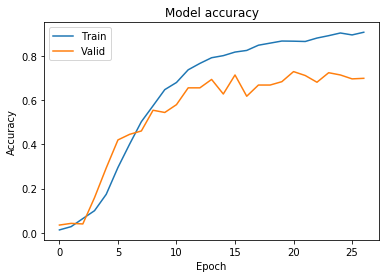

In [25]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## Refinement

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

# Model saving callback
checkpointer = ModelCheckpoint(filepath='finetune_solution_best.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit(train_X,
    train_y,
    epochs=epochs,
    callbacks=[checkpointer, early_stopping],
    batch_size=10,
    validation_data=(valid_X, valid_y))

Train on 1484 samples, validate on 395 samples
Epoch 1/100
1484/1484 [==============================] - 14s - loss: 5.1454 - acc: 0.0067 - val_loss: 4.9587 - val_acc: 0.0203
Epoch 2/100
1484/1484 [==============================] - 11s - loss: 4.9711 - acc: 0.0202 - val_loss: 4.9192 - val_acc: 0.0278
Epoch 3/100
1484/1484 [==============================] - 10s - loss: 4.9162 - acc: 0.0142 - val_loss: 4.9006 - val_acc: 0.0278
Epoch 4/100
1484/1484 [==============================] - 11s - loss: 4.8751 - acc: 0.0216 - val_loss: 4.8390 - val_acc: 0.0532
Epoch 5/100
1484/1484 [==============================] - 11s - loss: 4.7928 - acc: 0.0296 - val_loss: 4.7829 - val_acc: 0.0532
Epoch 6/100
1484/1484 [==============================] - 11s - loss: 4.7172 - acc: 0.0458 - val_loss: 4.6991 - val_acc: 0.0759
Epoch 7/100
1484/1484 [==============================] - 11s - loss: 4.6216 - acc: 0.0667 - val_loss: 4.6413 - val_acc: 0.1038
Epoch 8/100
1484/1484 [==============================] - 11s - l

1484/1484 [==============================] - 11s - loss: 2.0084 - acc: 0.6590 - val_loss: 2.5242 - val_acc: 0.6532
Epoch 29/100
1484/1484 [==============================] - 11s - loss: 1.8972 - acc: 0.6846 - val_loss: 2.4181 - val_acc: 0.7266
Epoch 30/100
1484/1484 [==============================] - 10s - loss: 1.8298 - acc: 0.6927 - val_loss: 2.3886 - val_acc: 0.7190
Epoch 31/100
1484/1484 [==============================] - 10s - loss: 1.7406 - acc: 0.7204 - val_loss: 2.3143 - val_acc: 0.7139
Epoch 32/100
1484/1484 [==============================] - 11s - loss: 1.6514 - acc: 0.7305 - val_loss: 2.2571 - val_acc: 0.7367
Epoch 33/100
1484/1484 [==============================] - 11s - loss: 1.5681 - acc: 0.7695 - val_loss: 2.1964 - val_acc: 0.7342
Epoch 34/100
1484/1484 [==============================] - 11s - loss: 1.4694 - acc: 0.7702 - val_loss: 2.1183 - val_acc: 0.7342
Epoch 35/100
1484/1484 [==============================] - 10s - loss: 1.4221 - acc: 0.7864 - val_loss: 2.0875 - val_a

1484/1484 [==============================] - 11s - loss: 0.5677 - acc: 0.9420 - val_loss: 1.4252 - val_acc: 0.8076
Epoch 60/100
1484/1484 [==============================] - 11s - loss: 0.5448 - acc: 0.9549 - val_loss: 1.4023 - val_acc: 0.8076
Epoch 61/100
1484/1484 [==============================] - 11s - loss: 0.5246 - acc: 0.9522 - val_loss: 1.3913 - val_acc: 0.7975
Epoch 62/100
1484/1484 [==============================] - 11s - loss: 0.4949 - acc: 0.9535 - val_loss: 1.3797 - val_acc: 0.8177
Epoch 63/100
1484/1484 [==============================] - 11s - loss: 0.5051 - acc: 0.9562 - val_loss: 1.3667 - val_acc: 0.8127
Epoch 64/100
1484/1484 [==============================] - 10s - loss: 0.4732 - acc: 0.9481 - val_loss: 1.3556 - val_acc: 0.8101
Epoch 65/100
1484/1484 [==============================] - 10s - loss: 0.4652 - acc: 0.9650 - val_loss: 1.3332 - val_acc: 0.8101
Epoch 66/100
1484/1484 [==============================] - 10s - loss: 0.4676 - acc: 0.9629 - val_loss: 1.3306 - val_a

### Plot the refinement result

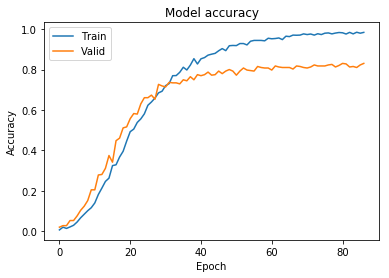

In [9]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## Evaluate on test dataset

In [10]:
# Evaluate the init solution with test data
model.load_weights('solution_best.h5')
model.evaluate(test_X, test_y, 149)

149/149 [==============================] - 0s


[1.9530375003814697, 0.65100675821304321]

In [11]:
# Evaluate the final solution with test data
model.load_weights('finetune_solution_best.h5')
model.evaluate(test_X, test_y, 149)

149/149 [==============================] - 0s


[1.2717722654342651, 0.83221477270126343]

## Validate the robustness

In [12]:
# Generate data augmentation to check the robustness of the final model
augmented_datagen = ImageDataGenerator(
        rescale=1. / 255,      # Normalize pixel values to [0,1]
        shear_range=0.2,       # Randomly applies shearing transformation
        zoom_range=0.2,        # Randomly applies shearing transformation
        horizontal_flip=True)  # Randomly flip the images

# Retrieve images and their classes for train and validation sets
train_gen = augmented_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode=None,
        shuffle=False)

model_vgg = applications.VGG16(include_top=False, weights='imagenet')

bottleneck_features_train = model_vgg.predict_generator(train_gen, nb_train_samples)
np.save(open('data/augmented_bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

Found 1484 images belonging to 149 classes.


In [19]:
train_X = np.load(open('data/augmented_bottleneck_features_train.npy', 'rb'))
train_y = to_categorical(train_gen.classes, num_classes=nb_classes)

model = generate_model(train_X)
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

# Model saving callback
checkpointer = ModelCheckpoint(filepath='finetune_augmented_solution_best.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=10)

history = model.fit(
    train_X,
    train_y,
    epochs=epochs,
    callbacks=[checkpointer, early_stopping],
    batch_size=10,
    validation_data=(valid_X, valid_y))

Train on 1484 samples, validate on 395 samples
Epoch 1/100
1484/1484 [==============================] - 11s - loss: 5.1428 - acc: 0.0088 - val_loss: 4.9644 - val_acc: 0.0101
Epoch 2/100
1484/1484 [==============================] - 11s - loss: 4.9800 - acc: 0.0094 - val_loss: 4.9512 - val_acc: 0.0152
Epoch 3/100
1484/1484 [==============================] - 11s - loss: 4.9454 - acc: 0.0142 - val_loss: 4.9194 - val_acc: 0.0304
Epoch 4/100
1484/1484 [==============================] - 10s - loss: 4.9037 - acc: 0.0229 - val_loss: 4.8986 - val_acc: 0.0278
Epoch 5/100
1484/1484 [==============================] - 11s - loss: 4.8596 - acc: 0.0270 - val_loss: 4.8609 - val_acc: 0.0354
Epoch 6/100
1484/1484 [==============================] - 11s - loss: 4.8143 - acc: 0.0330 - val_loss: 4.7936 - val_acc: 0.0506
Epoch 7/100
1484/1484 [==============================] - 11s - loss: 4.7584 - acc: 0.0404 - val_loss: 4.7473 - val_acc: 0.0582
Epoch 8/100
1484/1484 [==============================] - 10s - l

1484/1484 [==============================] - 11s - loss: 2.6460 - acc: 0.4912 - val_loss: 3.1455 - val_acc: 0.5291
Epoch 28/100
1484/1484 [==============================] - 10s - loss: 2.5503 - acc: 0.5270 - val_loss: 3.0730 - val_acc: 0.5139
Epoch 29/100
1484/1484 [==============================] - 11s - loss: 2.4768 - acc: 0.5431 - val_loss: 3.0230 - val_acc: 0.5570
Epoch 30/100
1484/1484 [==============================] - 10s - loss: 2.3672 - acc: 0.5391 - val_loss: 2.9708 - val_acc: 0.5215
Epoch 31/100
1484/1484 [==============================] - 11s - loss: 2.2616 - acc: 0.5782 - val_loss: 2.8847 - val_acc: 0.5747
Epoch 32/100
1484/1484 [==============================] - 11s - loss: 2.1959 - acc: 0.6011 - val_loss: 2.8062 - val_acc: 0.5722
Epoch 33/100
1484/1484 [==============================] - 11s - loss: 2.0968 - acc: 0.6132 - val_loss: 2.7330 - val_acc: 0.6203
Epoch 34/100
1484/1484 [==============================] - 10s - loss: 2.0191 - acc: 0.6361 - val_loss: 2.6730 - val_a

1484/1484 [==============================] - 10s - loss: 0.8100 - acc: 0.9124 - val_loss: 1.8897 - val_acc: 0.6962
Epoch 58/100
1484/1484 [==============================] - 11s - loss: 0.8555 - acc: 0.8888 - val_loss: 1.8765 - val_acc: 0.7089
Epoch 59/100
1484/1484 [==============================] - 11s - loss: 0.7801 - acc: 0.9097 - val_loss: 1.8552 - val_acc: 0.7139
Epoch 60/100
1484/1484 [==============================] - 11s - loss: 0.7548 - acc: 0.9144 - val_loss: 1.8375 - val_acc: 0.7038
Epoch 61/100
1484/1484 [==============================] - 10s - loss: 0.7390 - acc: 0.9084 - val_loss: 1.8197 - val_acc: 0.7089
Epoch 62/100
1484/1484 [==============================] - 11s - loss: 0.7081 - acc: 0.9185 - val_loss: 1.7974 - val_acc: 0.7316
Epoch 63/100
1484/1484 [==============================] - 10s - loss: 0.6673 - acc: 0.9299 - val_loss: 1.7723 - val_acc: 0.7165
Epoch 64/100
1484/1484 [==============================] - 10s - loss: 0.6696 - acc: 0.9212 - val_loss: 1.7648 - val_a

1484/1484 [==============================] - 10s - loss: 0.3882 - acc: 0.9697 - val_loss: 1.5097 - val_acc: 0.7392
Epoch 89/100
1484/1484 [==============================] - 10s - loss: 0.3550 - acc: 0.9717 - val_loss: 1.5006 - val_acc: 0.7392
Epoch 90/100
1484/1484 [==============================] - 11s - loss: 0.3452 - acc: 0.9751 - val_loss: 1.4904 - val_acc: 0.7494
Epoch 91/100
1484/1484 [==============================] - 10s - loss: 0.3339 - acc: 0.9757 - val_loss: 1.4899 - val_acc: 0.7494
Epoch 00090: early stopping


In [20]:
model.load_weights('finetune_augmented_solution_best.h5')
model.evaluate(test_X, test_y, 149)

149/149 [==============================] - 0s


[1.5792747735977173, 0.76510071754455566]

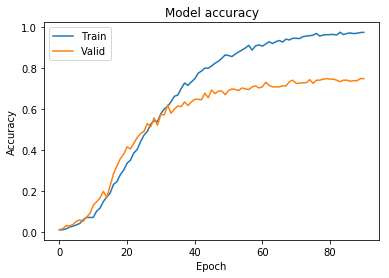

In [21]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()